In [1]:
import pandas as pd
import datetime
import numpy as np
import yfinance as yf

def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.concat([opt.calls, opt.puts])
        opt['expirationDate'] = e
        options = pd.concat([options, opt], ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365.25
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

SPX_options_chain = options_chain("^SPX")
print(SPX_options_chain)

            contractSymbol  strike    bid    ask  volume  openInterest  \
0      SPXW240110C04050000  4050.0  701.0  707.8     2.0           0.0   
1      SPXW240110C04100000  4100.0  651.1  657.8     NaN           0.0   
2      SPXW240110C04275000  4275.0  476.1  482.8     NaN           0.0   
3      SPXW240110C04300000  4300.0  451.3  458.0     7.0           0.0   
4      SPXW240110C04350000  4350.0  401.3  408.0    37.0           0.0   
...                    ...     ...    ...    ...     ...           ...   
12912   SPX291221P04800000  4800.0  476.2  627.8     1.0           0.0   
12913   SPX291221P04900000  4900.0  505.3  658.8    50.0           0.0   
12914   SPX291221P05000000  5000.0  535.0  690.4     3.0           0.0   
12915   SPX291221P05100000  5100.0  565.3  722.7     NaN           0.0   
12916   SPX291221P05600000  5600.0  729.5  896.1     1.0           0.0   

       impliedVolatility inTheMoney expirationDate       dte   CALL    mark  
0               1.361331        1

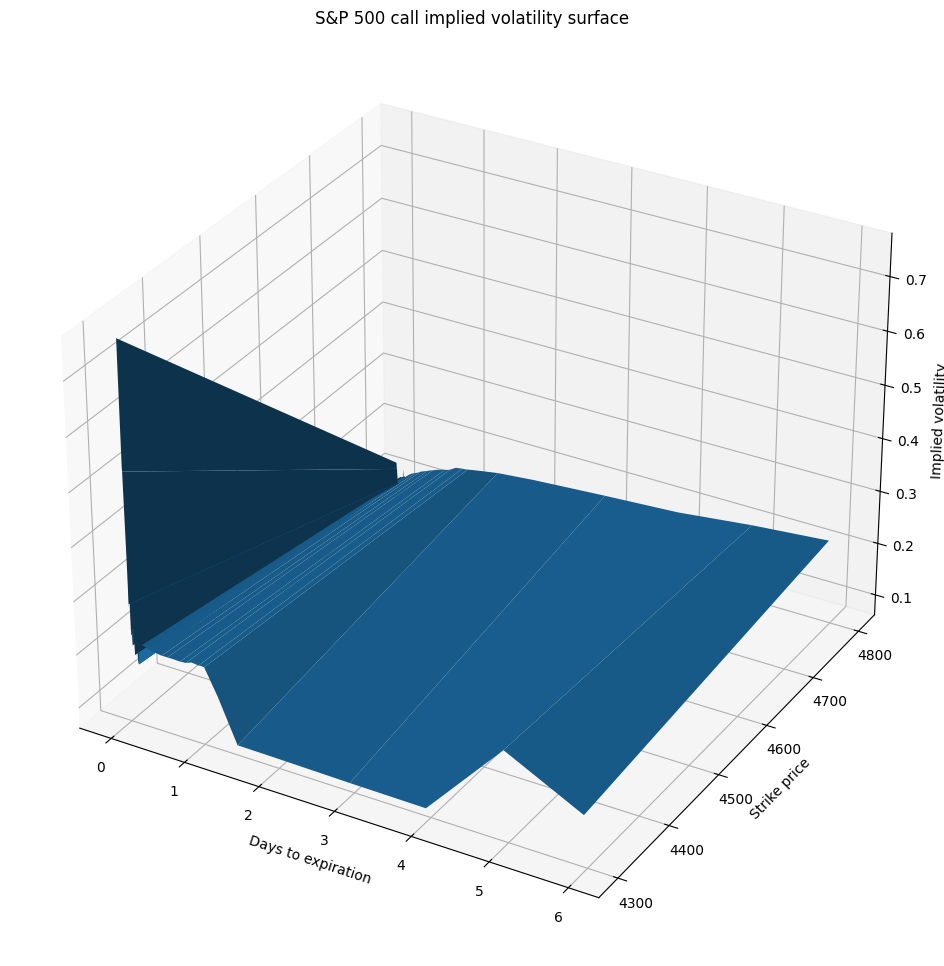

In [2]:
import matplotlib.pyplot as plt

surface = (
    SPX_options_chain[['dte', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='dte')
    .dropna()
)
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection='3d')
x, y, z = surface.columns.values, surface.index.values, surface.values
X, Y = np.meshgrid(x, y)

ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('S&P 500 call implied volatility surface')

ax.plot_surface(X, Y, z)


In [3]:
# Construct a full volatility surface
volSurface = (
    SPX_options_chain[SPX_options_chain['CALL'] == True][['dte', 'strike', 'mark']]
    .pivot_table(values='mark', index='dte', columns='strike')
    #.fillna(0.0001)
)
volSurface = volSurface[volSurface.index > 0.1]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.781946499195987e-10
        x: [ 2.000e+00]
      nit: 0
      jac: [ 3.225e-08]
 hess_inv: [[1]]
     nfev: 2
     njev: 1


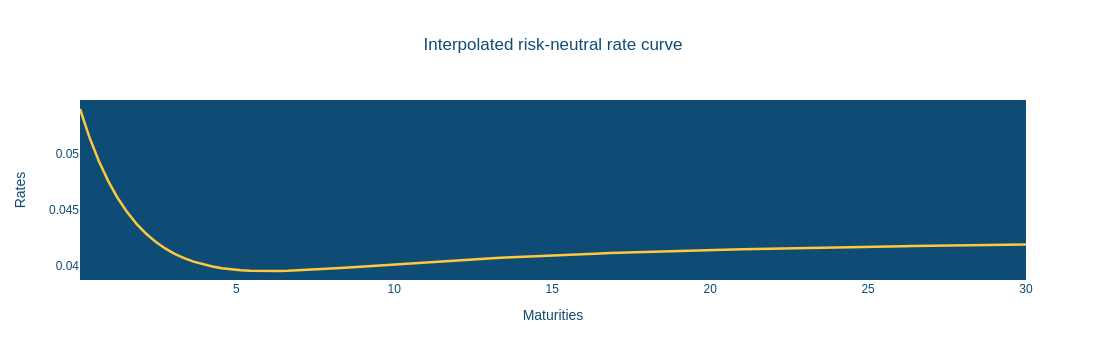

In [9]:
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.express as px

irx = yf.download("^IRX") # 13 weeks
fvx = yf.download("^FVX") # 5 years
tnx = yf.download("^TNX") # 10 years
tyx = yf.download("^TYX") # 30 years
bonds = [bond['Adj Close'] for bond in [irx, fvx, tnx, tyx]]
bonds = pd.concat(bonds, axis=1).set_axis(['13W', '5Y', '10Y', '30Y'], axis=1)

rates = np.array(bonds.tail(1).values[0]) * 0.01
maturities = np.array([1/4, 5, 10, 30])

curve, status = calibrate_ns_ols(maturities, rates)

print(status)

# Plot the graph to visualize the shape
mats = np.linspace(0.05, 30, 101)
rates = curve(mats)
fig = go.Figure(go.Scatter(x= mats, y = rates, line = dict(color='#ffc93c', width=2.5)))
fig.update_layout(
    font_color="#0f4c75",
    title_text='Interpolated risk-neutral rate curve', 
    title_x=0.5,
)
fig.update_xaxes(title="Maturities")
fig.update_yaxes(title="Rates")
fig.update_layout(plot_bgcolor='#0f4c75')
fig.update_layout(plot_bgcolor='#0f4c75')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

In [12]:
'''
Full volatility surface and safe rates are prepared
Now it's time to run Heston model
'''
#Initialize parameters
sigma, kappa, theta, volvol, rho = 0.1, 0.1, 0.1, 0.1, 0.1

# Convert our vol surface to long to allow for a vectorized Heston pricing function
volSurfaceLong = volSurface.melt(ignore_index = False).reset_index()
volSurfaceLong.columns = ['maturity', 'strike', 'price']

# Calculate the risk free rate for each maturity
volSurfaceLong['rate'] = volSurfaceLong['maturity'].apply(curve)
volSurfaceLong = volSurfaceLong.dropna()
print(volSurfaceLong)

# Define global variables to be used in optimization
maturities = volSurfaceLong['maturity'].to_numpy('float')
strikes = volSurfaceLong['strike'].to_numpy('float')
marketPrices = volSurfaceLong['price'].to_numpy('float')
rates = volSurfaceLong['rate'].to_numpy('float')

       maturity   strike     price      rate
0      0.101300    200.0  4549.300  0.053525
4      0.177960    200.0  4545.300  0.052854
6      0.273785    200.0  4542.850  0.052055
8      0.350445    200.0  4538.650  0.051447
10     0.446270    200.0  4475.100  0.050723
...         ...      ...       ...       ...
11562  4.930869  10000.0     4.000  0.039636
11587  1.941136  12000.0     0.275  0.043414
11588  2.937714  12000.0     0.750  0.041207
11589  3.934292  12000.0     1.750  0.040108
11590  4.930869  12000.0     8.950  0.039636

[3377 rows x 4 columns]


In [13]:
# Parallel computation using numba
from numba import jit, njit, prange, float64,complex64
from numba import cuda

i = complex(0,1)

# To be used in the Heston pricer
@jit
def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):
    # To be used a lot
    prod = rho * sigma *i *s 
    
    # Calculate d
    d1 = (prod - kappa)**2
    d2 = (sigma**2) * (i*s + s**2)
    d = np.sqrt(d1 + d2)
    
    # Calculate g
    g1 = kappa - prod - d
    g2 = kappa - prod + d
    g = g1/g2
    
    # Calculate first exponential
    exp1 = np.exp(np.log(St) * i *s) * np.exp(i * s* r* T)
    exp2 = 1 - g * np.exp(-d *T)
    exp3 = 1- g
    mainExp1 = exp1 * np.power(exp2/ exp3, -2 * theta * kappa/(sigma **2))
    
    # Calculate second exponential
    exp4 = theta * kappa * T/(sigma **2)
    exp5 = volvol/(sigma **2)
    exp6 = (1 - np.exp(-d * T))/(1 - g * np.exp(-d * T))
    mainExp2 = np.exp((exp4 * g1) + (exp5 *g1 * exp6))
    
    return (mainExp1 * mainExp2)

# Heston Pricer (allow for parallel processing with numba)
@jit(forceobj=True)
def priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    P, iterations, maxNumber = 0,1000,100
    ds = maxNumber/iterations
    
    element1 = 0.5 * (St - K * np.exp(-r * T))
    
    # Calculate the complex integral
    # Using j instead of i to avoid confusion
    for j in prange(1, iterations):
        s1 = ds * (2*j + 1)/2
        s2 = s1 - i
        
        numerator1 = fHeston(s2,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1,  St, K, r, T, sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) *i *s1
        
        P = P + ds *(numerator1 - numerator2)/denominator
    
    element2 = P/np.pi
    
    return np.real((element1 + element2))

/tmp/ipykernel_38631/3225399598.py:9: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



In [15]:
from lmfit import Parameters, minimize
from scipy.optimize import dual_annealing

def iter_cb(params, iter, resid):
    parameters = [params['sigma'].value, 
                  params['kappa'].value, 
                  params['theta'].value, 
                  params['volvol'].value, 
                  params['rho'].value, 
                  np.sum(np.square(resid))]
    print(parameters) 
    
# This is the calibration function
def calibratorHeston(St, initialValues = [0.5,0.1,0.1,0.1,-1], 
                              lowerBounds = [1e-2,1e-2,1e-2,1e-2,-1], 
                              upperBounds = [10,10,10,10,1]):
    '''Implementation of the Levenberg Marquardt algorithm in Python to find the optimal value 
        based on a given volatility surface.
        
        Function to be minimized:
            Error = (MarketPrices - ModelPrices)/MarketPrices
        
    '''1) Define parameters
    =========================='''
    params = Parameters()
    params.add('sigma',value = initialValues[0], min = lowerBounds[0], max = upperBounds[0])
    params.add('kappa',value = initialValues[1], min = lowerBounds[1], max = upperBounds[1])
    params.add('theta',value = initialValues[2], min = lowerBounds[2], max = upperBounds[2])
    params.add('volvol', value = initialValues[3], min = lowerBounds[3], max = upperBounds[3])
    params.add('rho', value = initialValues[4], min = lowerBounds[4], max = upperBounds[4])
    
    
    '''2) Define objective function
    ================================'''
    objectiveFunctionHeston = lambda paramVect: (marketPrices - priceHestonMid(St, strikes,  
                                                                        rates, 
                                                                        maturities, 
                                                                        paramVect['sigma'].value,                         
                                                                        paramVect['kappa'].value,
                                                                        paramVect['theta'].value,
                                                                        paramVect['volvol'].value,
                                                                        paramVect['rho'].value))/marketPrices   
    
    '''3) Optimize parameters
    =============================='''
    result = minimize(objectiveFunctionHeston, 
                      params, 
                      method = 'leastsq',
                      iter_cb = iter_cb,
                      ftol = 1e-6,
                      nan_policy='omit')
    return(result)

# This calibration takes a while (About 1 hour)
calibratorHeston(4756)

[0.5, 0.10000000000000019, 0.10000000000000019, 0.10000000000000019, -1.0, inf]
[0.5, 0.10000000000000019, 0.10000000000000019, 0.10000000000000019, -1.0, inf]
[0.5, 0.10000000000000019, 0.10000000000000019, 0.10000000000000019, -1.0, inf]
[0.5000242543822875, 0.10000000000000019, 0.10000000000000019, 0.10000000000000019, -1.0, inf]
[0.5, 0.10001303307827435, 0.10000000000000019, 0.10000000000000019, -1.0, inf]
[0.5, 0.10000000000000019, 0.10001303307827435, 0.10000000000000019, -1.0, inf]
[0.5, 0.10000000000000019, 0.10000000000000019, 0.10001303307827435, -1.0, inf]
[0.5, 0.10000000000000019, 0.10000000000000019, 0.10000000000000019, -0.9999999998766299, inf]
[0.14355546751730666, 7.119079027634744, 5.462614952293781, 0.028585309962045495, -0.8752109193119166, inf]
[0.47662320136000674, 0.16093919406953916, 0.18901265616725352, 0.08294211754873348, 0.9189957667288722, inf]
[0.5011280577697859, 0.10531549544175922, 0.10170690012070344, 0.09825809225676031, -0.9925132059768306, inf]
[0